In [1]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def sample_jester_data(file_name, context_dim = 32, num_actions = 8, num_contexts = 19181,
    shuffle_rows=True, shuffle_cols=False):
    """Samples bandit game from (user, joke) dense subset of Jester dataset.
    Args:
    file_name: Route of file containing the modified Jester dataset.
    context_dim: Context dimension (i.e. vector with some ratings from a user).
    num_actions: Number of actions (number of joke ratings to predict).
    num_contexts: Number of contexts to sample.
    shuffle_rows: If True, rows from original dataset are shuffled.
    shuffle_cols: Whether or not context/action jokes are randomly shuffled.
    Returns:
    dataset: Sampled matrix with rows: (context, rating_1, ..., rating_k).
    opt_vals: Vector of deterministic optimal (reward, action) for each context.
    """
    np.random.seed(0)
    with tf.gfile.Open(file_name, 'rb') as f:
        dataset = np.load(f)
    if shuffle_cols:
        dataset = dataset[:, np.random.permutation(dataset.shape[1])]
    if shuffle_rows:
        np.random.shuffle(dataset)
    dataset = dataset[:num_contexts, :]
    assert context_dim + num_actions == dataset.shape[1], 'Wrong data dimensions.'
    opt_actions = np.argmax(dataset[:, context_dim:], axis=1)
    opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)])
    return dataset, opt_rewards, opt_actions

TensorFlow 1.x selected.


In [2]:
dataset, opt_rewards, opt_actions = sample_jester_data("jester_data_40jokes_19181users.npy")

In [69]:
n = 18000 # number of users
k = 32 # number of features
n_a = 8 # number of actions
D = [i[:32] for i in dataset[:18000]] # training data
y = [i[32:] for i in dataset[:18000]] # target of the training data
X_test = [i[:32] for i in dataset[18000:]]
y_test = [i[32:] for i in dataset[18000:]]
y_optimal = opt_rewards[18000:]
test_n = len(dataset) - 18000

In [76]:
alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
regrets = []
for m in range(len(alpha)):
    choices = np.zeros(n)
    b = np.zeros((n_a, k)) # b_a = D_a'y_a
    A = np.zeros((n_a, k, k)) # A_a = D_a'D_a + I, for each action we have a k by k matrix
    for a in range(n_a):
        A[a] = np.identity(k)
    th_hat = np.zeros((n_a, k)) # our temporary feature vectors
    p = np.zeros(n_a)
    for i in range(n):
        x_i = D[i]
        for a in range(n_a):
            A_inv = np.linalg.inv(A[a])
            th_hat[a] = A_inv.dot(b[a]) # theta = inverse(D_a'D_a + I)D_a'y_a
            ta = x_i.dot(A_inv).dot(x_i) # variance
            a_upper_ci = alpha[m] * np.sqrt(ta)
            a_mean = th_hat[a].dot(x_i)
            p[a] = a_mean + a_upper_ci
        # randomly add a very small value to pick one from ties
        p = p + (np.random.random(len(p)) * 0.000001)
        choices[i] = p.argmax() # choose the highest

        # update the input vector
        A[int(choices[i])] += np.outer(x_i, x_i)
        b[int(choices[i])] += y[i][int(choices[i])] * x_i # b is the multiplication of reward by context

    rewards_pred = []
    for i in range(test_n):
        x_i = X_test[i]
        p_pred = th_hat.dot(x_i)
        choice = p_pred.argmax()
        reward_pred = y_test[i][int(choice)]
        rewards_pred.append(reward_pred)
    regret = y_optimal - rewards_pred
    regrets.append(regret)


alpha = 0.3 gives the best performance. Regret is as follows.

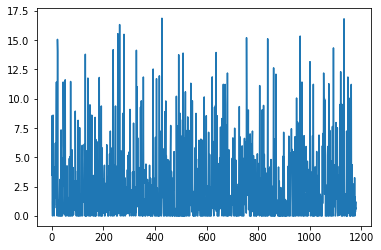

In [87]:
best_index = np.array([np.mean(i) for i in regrets]).argmin()
best_alpha = alpha[best_index]
min_regret = regrets[best_index]
plt.plot(min_regret)
plt.show()

In [88]:
best_alpha

0.3